# Square lattice asymmetric

**authors:** Joseph Marcus
 
Here I simulate genetic data under the coalescent in a square lattice with asymmetric migration and explore the fit of different ways to compute expected genetic distances on simulated genotypes.

Lets load the necessary packages and modules to get started 

In [40]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../code/")
from habitat import *
from genotype_simulator import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Plot size configuration

In [41]:
sns.set_style('white')
plt.style.use('bmh')
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = 8, 6

## Setup the habitat

Here we define a square lattice with 8 rows and 8 columns so we have 64 demes in total

In [42]:
hab = SquareLattice(8, 8)

Next we need to define a migration surface which is a function on the nodes of the graph that define edge weights. Here set the migration surface such that it is uniform in one direction on the x-axis and 10 times lower on the y-axis

In [60]:
def uniform_asym_migration(self):
    """            
    Returns:
        g: nx.graph
            regular lattice with assigned weights
    """
    for i,j in self.g.edges():
        if (self.s[i, 1] == self.s[j, 1]):
            self.g[i][j]['m'] = 2.
        else: 
            self.g[i][j]['m'] = .2
        
    self.m = nx.adjacency_matrix(self.g, weight='m')

    # set upper tri of migration matrix to 0.
    triu_idx = np.triu_indices(self.m.shape[0], 1)
    self.m[triu_idx] = 0.0
    self.m = self.m.toarray()

We then assign this method to the habitat object

In [61]:
# assign the migration method
hab.migration_surface = uniform_asym_migration
# create the migration matrix
hab.migration_surface(hab)
# compute graph laplacian
hab.get_graph_lapl()

/Users/josephmarcus/src/anaconda3/envs/sprw/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Lets visualize triangular lattice with edge widths proportional to the defined edge weights, note we multiply the weights by some constant just for visualization purposes. Additional the nodes have a color scheme based on their position on the map, particularly the x position difference is emphasized more than the y. the habitat

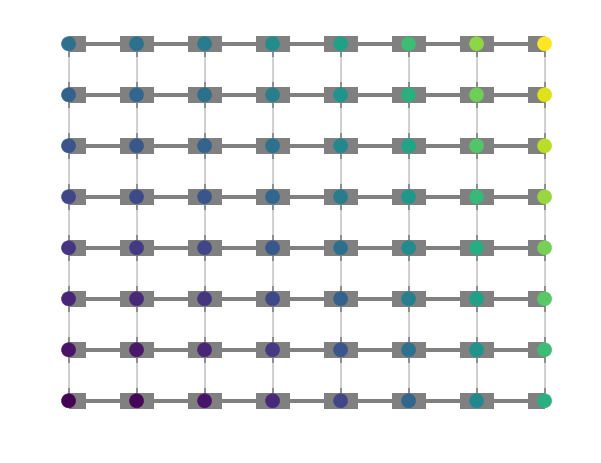

In [62]:
hab.plot_habitat(200, 2, True)

**TODO** fix the arrows in the plot they are too big by default!

As expected we see that the migration matrix $\mathbf{M}$ is extremely sparse as only neighboring nodes are connected

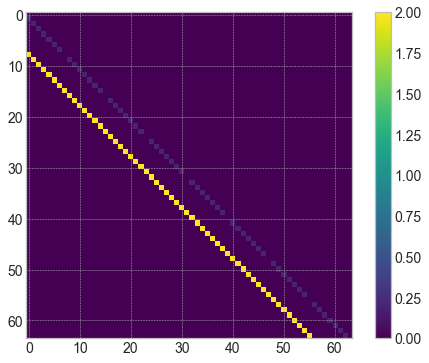

In [63]:
hab.plot_migration_matrix()

## Simulate genotypes

Here we simulate genotypes under the coalescent using msprime ... this may take a bit of time. Specifically we simulate 10 haploid individuals per deme in 10000 independent regions of the genome. See `../code/genotype_simulator.py` for default params and implementation of the simulation object.

In [48]:
sim_path = path = "../output/simulations/sqlat_asym.pkl"
geno = GenotypeSimulator(hab, sim_path, n_rep=1e4)

print(geno.y.shape)

(640, 7823)


Here we visualize the site frequency spectrum which deviates from the neutral expectation. We see a deflation of common variants except for the very common variants at end the frequency spectrum. I'm not sure whats causing this.

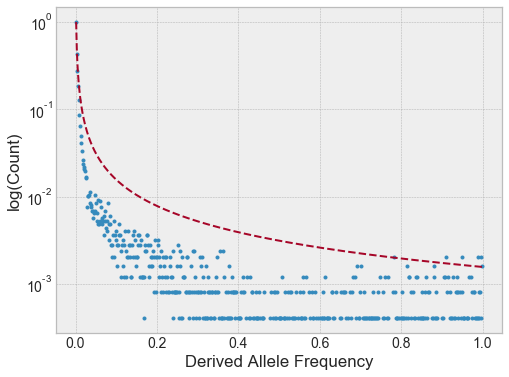

In [49]:
geno.plot_sfs()

Lets filter out too rare variants leavings us with fewer SNPs

In [50]:
geno.filter_rare_var()
print(geno.y.shape)

(640, 1431)


Lets peform PCA on the genotype matrix and visualize the first two PCs. Note that I center and scale the data matrix before running PCA.

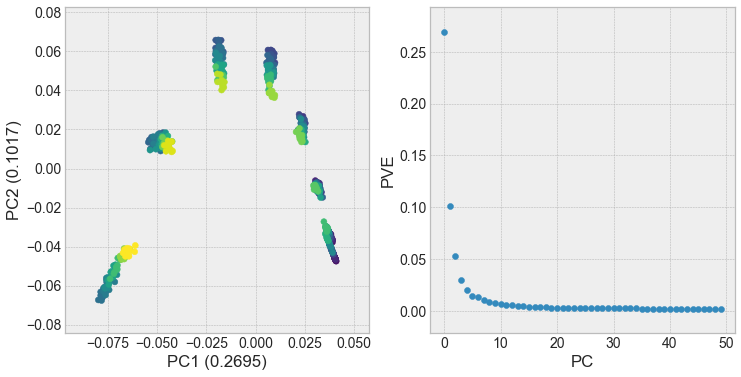

In [51]:
geno.pca()
geno.plot_pca(geno.pcs, geno.pves)

## Expected genetic distances

We can see the graph laplacian is sparse as $\mathbf{M}$ is sparse and as expected is not symmetric because the migration matrix is not symmetric

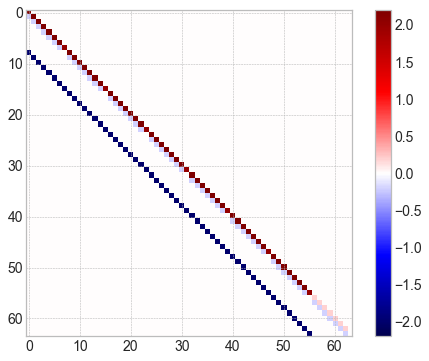

In [52]:
hab.plot_precision_matrix(hab.l)

We can see that $\mathbf{L}\mathbf{L}^T$ is also sparse but not as sparse. It seems to have an additional off-diagonal band and is symmetric!

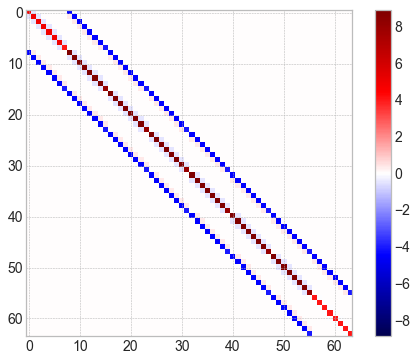

In [53]:
hab.plot_precision_matrix(hab.l @ hab.l.T)

In [54]:
# lower triangular indicies
tril_idx = np.tril_indices(geno.n, -1)

# observed genetic distance
d_geno = geno.geno_dist()
d_geno_tril = d_geno[tril_idx]

# geographic distance
d_geo = geno.node_to_obs_mat(hab.geo_dist(), geno.n, geno.v)
d_geo_tril = d_geo[tril_idx]

# resistence distance
d_res = geno.node_to_obs_mat(hab.rw_dist(hab.l), geno.n, geno.v)
d_res_tril = d_res[tril_idx]

# random-walk distance
d_rw = geno.node_to_obs_mat(hab.rw_dist(hab.l @ hab.l.T), geno.n, geno.v)
d_rw_tril = d_rw[tril_idx]

Unfortunately, I can't get the solver to work for this simulation. I'll keep playing with some of the hyper parameters. This really convinces me though why its advantageous to avoid solving coalescent time system during inference (its slow and potentially unstable).

In [55]:
# coalescent distance
d_coal = geno.node_to_obs_mat(hab.coal_dist(tol=1e-15), geno.n, geno.v)
d_coal_tril = d_coal[tril_idx]

geno.plot_dist(d_coal_tril, d_geno_tril, "Coalescent Distance", "Genetic Distance")
print('coal r2 = {}'.format(np.corrcoef(d_coal_tril, d_geno_tril)[0, 1]))

ValueError: On entry to DGELSD parameter number 4 had an illegal value

geo r2 = 0.4767245370673476


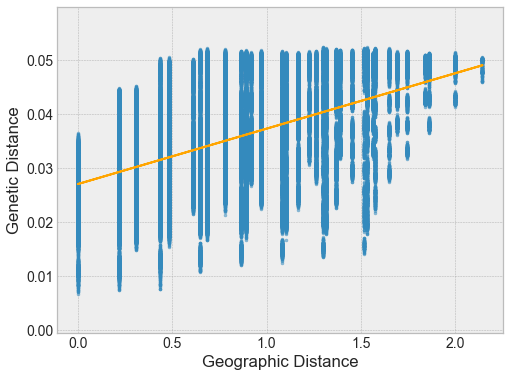

In [56]:
geno.plot_dist(d_geo_tril, d_geno_tril, "Geographic Distance", "Genetic Distance")
print('geo r2 = {}'.format(np.corrcoef(d_geo_tril, d_geno_tril)[0, 1]))

res r2 = -0.025699423146682856


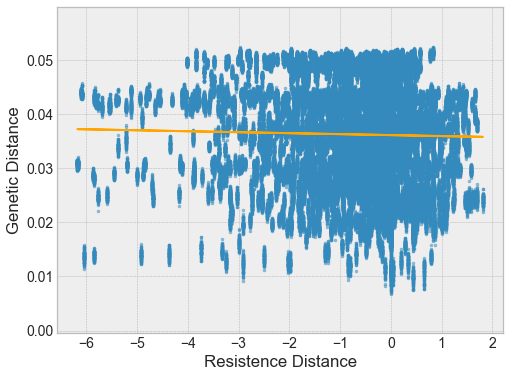

In [57]:
geno.plot_dist(d_res_tril, d_geno_tril, "Resistence Distance", "Genetic Distance")
print('res r2 = {}'.format(np.corrcoef(d_res_tril, d_geno_tril)[0, 1]))

rw r2 = 0.6501524083836742


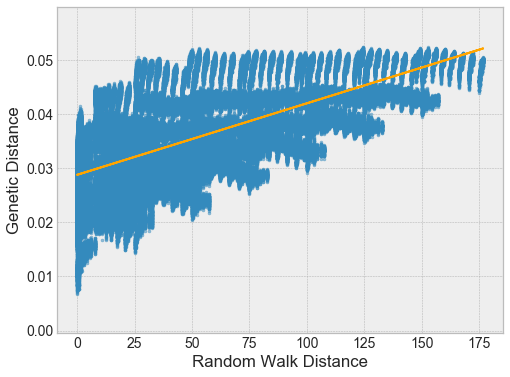

In [58]:
geno.plot_dist(d_rw_tril, d_geno_tril, "Random Walk Distance", "Genetic Distance")
print('rw r2 = {}'.format(np.corrcoef(d_rw_tril, d_geno_tril)[0, 1]))

In [59]:
print('geo r2 = {}'.format(np.corrcoef(d_geo_tril, d_geno_tril)[0, 1]))
print('res r2 = {}'.format(np.corrcoef(d_res_tril, d_geno_tril)[0, 1]))
print('rw r2 = {}'.format(np.corrcoef(d_rw_tril, d_geno_tril)[0, 1]))

geo r2 = 0.4767245370673476
res r2 = -0.025699423146682856
rw r2 = 0.6501524083836742


It seems like the random walk distance can actually capture some signal of asymmetry although the fit looks quite strange. This is promising though as perhaps it suggests that the random-walk distance can fit asymmetry and barriers!